In [32]:
import pandas as pd
import numpy as np
df = pd.read_csv("transmission_data.csv")
Wavelength = df["CENTRALWAVELNG"].to_numpy()
bins = df["BANDWIDTH"].to_numpy()
Flux = df["PL_TRANDEP"].to_numpy()/100
Flux_Error = df["PL_RADJERR1"].to_numpy()/100



Text(0, 0.5, 'Transit dip')

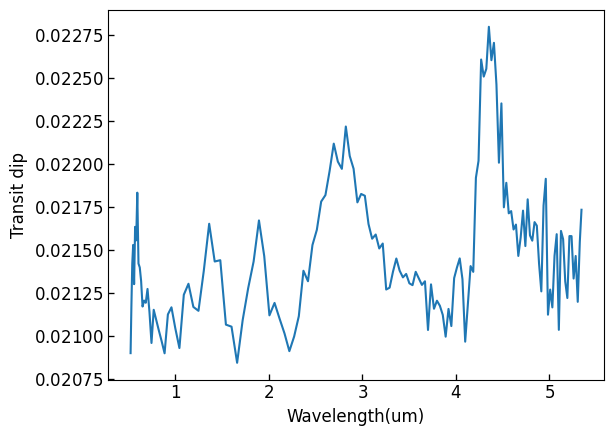

In [78]:
import matplotlib.pyplot as plt
plt.errorbar(Wavelength,Flux)
plt.xlabel(r"Wavelength(um)")
plt.ylabel("Transit dip")

In [34]:
import copy
import os

import matplotlib.pyplot as plt
import numpy as np

import petitRADTRANS.physical_constants as cst
from petitRADTRANS.plotlib import plot_result_corner
from petitRADTRANS.retrieval.retrieval import Retrieval
from petitRADTRANS.spectral_model import SpectralModel

In [35]:
from petitRADTRANS.planet import Planet

planet = Planet.get('WASP-39 b')


In [36]:
forward_model_nirspec = SpectralModel(
    # Radtrans parameters
    pressures=np.logspace(-6, 2, 100),
    line_species=[
        'CH4.R300',
        'CO-NatAbund.R300',
        'CO2.R300',
        'H2O__POKAZATEL.R300',
        'SO2.R300'
    ],
    rayleigh_species=['H2', 'He'],
    gas_continuum_contributors=['H2-H2', 'H2-He'],
    # SpectralModel parameters
    # Planet parameters
    planet_radius=planet.radius,
    reference_gravity=planet.reference_gravity,
    reference_pressure=planet.reference_pressure,
    star_radius=planet.star_radius,

    # Temperature profile parameters
    temperature_profile_mode='guillot',
    intrinsic_temperature=600,
    guillot_temperature_profile_gamma=0.8,
    temperature=planet.equilibrium_temperature,
    # Cloud parameters
    opaque_cloud_top_pressure=3e-2,
    cloud_fraction=1.0,
    # Mass fractions
    metallicity=10,
    co_ratio=0.3,
    haze_factor = 7,
    
    use_equilibrium_chemistry=False,
    imposed_mass_fractions={
        'CH4.R300': 1e-6,
        'CO-NatAbund.R300': 1e-2,
        'CO2.R300': 1e-4,
        'H2O__POKAZATEL.R300': 1e-3,
        'SO2.R300': 1e-4
    },
    filling_species={
        'H2': 37,
        'He': 12
    },
    # Observation parameters
    rebinned_wavelengths=Wavelength * 1e-4,  # (cm)
    bin_widths=bins * 1e-4,
    rebin_range_margin_power=1,  # increase the margin of the optimal wavelengths boundaries by 100 nm (1e-1 * 1 um)
    convolve_resolving_power=100  # used for the convolution
)

Loading Radtrans opacities...
 Loading line opacities of species 'CH4.R300' from file '/home/saurav/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__HITEMP.R300_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO-NatAbund.R300' from file '/home/saurav/petitRADTRANS/input_data/opacities/lines/correlated_k/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R300_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2.R300' from file '/home/saurav/petitRADTRANS/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R300_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'H2O__POKAZATEL.R300' from file '/home/saurav/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R300_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'SO2.R300' from file '/home/saurav/petitRADTRANS/input_data/opacities/lines/correlated_k/SO2/32S-1

In [39]:
retrieved_parameters = {
    'temperature': {
        'prior_parameters': [100, 4000],  # (K)
        'prior_type': 'uniform',
        'figure_title': r'T',
        'figure_label': r'T (K)'
    },
    'planet_radius': {
       'prior_parameters': np.array([0.8, 1.6]) * cst.r_jup,  # (s)
       'prior_type': 'uniform',
       'figure_title': r'$R_p$',
       'figure_label': r'$R_p$)'
    },
    'CH4.R300': {
        'prior_parameters': [-12, 0],  # (MMR)
        'prior_type': 'uniform',
        'figure_title': r'[CH4]',
        'figure_label': r'$\log_{10}$(MMR) CH4'
    },
    'CO-NatAbund.R300': {
        'prior_parameters': [-12, 0],  # (MMR)
        'prior_type': 'uniform',
        'figure_title': r'[CO]',
        'figure_label': r'$\log_{10}$(MMR) CO'
    },
    'CO2.R300': {
        'prior_parameters': [-12, 0],  # (MMR)
        'prior_type': 'uniform',
        'figure_title': r'[CO$_2$]',
        'figure_label': r'$\log_{10}$(MMR) CO$_2$'
    },
    'H2O__POKAZATEL.R300': {
        'prior_parameters': [-12, 0],  # (MMR)
        'prior_type': 'uniform',
        'figure_title': r'[H$_2$O]',
        'figure_label': r'$\log_{10}$(MMR) H$_2$O'
    },
    'SO2.R300': {
        'prior_parameters': [-12, 0],  # (MMR)
        'prior_type': 'uniform',
        'figure_title': r'[SO$_2$]',
        'figure_label': r'$\log_{10}$(MMR) SO$_2$'
    },
    'log10_opaque_cloud_top_pressure': {
        'prior_parameters': [-10, 2],  # (bar)
        'prior_type': 'uniform',
        'figure_title': r'[$P_c$]',
        'figure_label': r'$\log_{10}(P_c)$ ([Pa])',
        'figure_offset': 5  # [bar] to [Pa]
    },
    'cloud_fraction': {
        'prior_parameters': [0, 1],
        'prior_type': 'uniform',
        'figure_title': r'$c_f$',
        'figure_label': r'$c_f$'
    },
}


In [40]:
data = {  # multiple data can be retrieved by adding multiple keys
    'NIRSpec': forward_model_nirspec.init_data(
        # Data parameters
        data_spectrum=1 - Flux,  # SpectralModel scale spectra using 1 - R_p/R_*
        data_wavelengths=Wavelength,
        data_uncertainties=Flux_Error,  # ⚠️ uncertainties artificially multiplied by 20 to speed up the retrieval in this example
        data_name='NIRSpec',
        # Retrieved parameters
        retrieved_parameters=retrieved_parameters,
        # Forward model post-processing parameters
        mode='transmission',
        scale=True,
        convolve=True,
        rebin=True
    )
}

In [41]:
retrieval_name = 'spectral_model_jwst_example_1_dataset'
retrieval_directory = os.path.join('.', 'results', retrieval_name)

retrieval = Retrieval.from_data(
    data=data,
    retrieved_parameters=retrieved_parameters,
    retrieval_name=retrieval_name,
    output_directory=retrieval_directory,
    run_mode='retrieval'
)

Using provided Radtrans object for data 'NIRSpec'...


In [42]:
run_retrieval = True

In [43]:
if run_retrieval:
    retrieval.run(
        n_live_points=80,
        resume=False,
    )

Starting retrieval spectral_model_jwst_example_1_dataset
Testing data 'NIRSpec':
 wavelengths:
  OK (no NaN, infinite, or negative value detected)
 spectrum:
  OK (no NaN, infinite, or negative value detected)
 uncertainties:
  OK (no NaN, infinite, or negative value detected)
Testing model function for data 'NIRSpec'...
No errors detected in the model functions!
Starting retrieval: spectral_model_jwst_example_1_dataset

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =   80
 dimensionality =    9
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.838710
Replacements:                                130
Total Samples:                               155
Nested Sampling ln(Z):             -42555.540968
Importance Nested Sampling ln(Z):    -158.476952 +/-  0.996

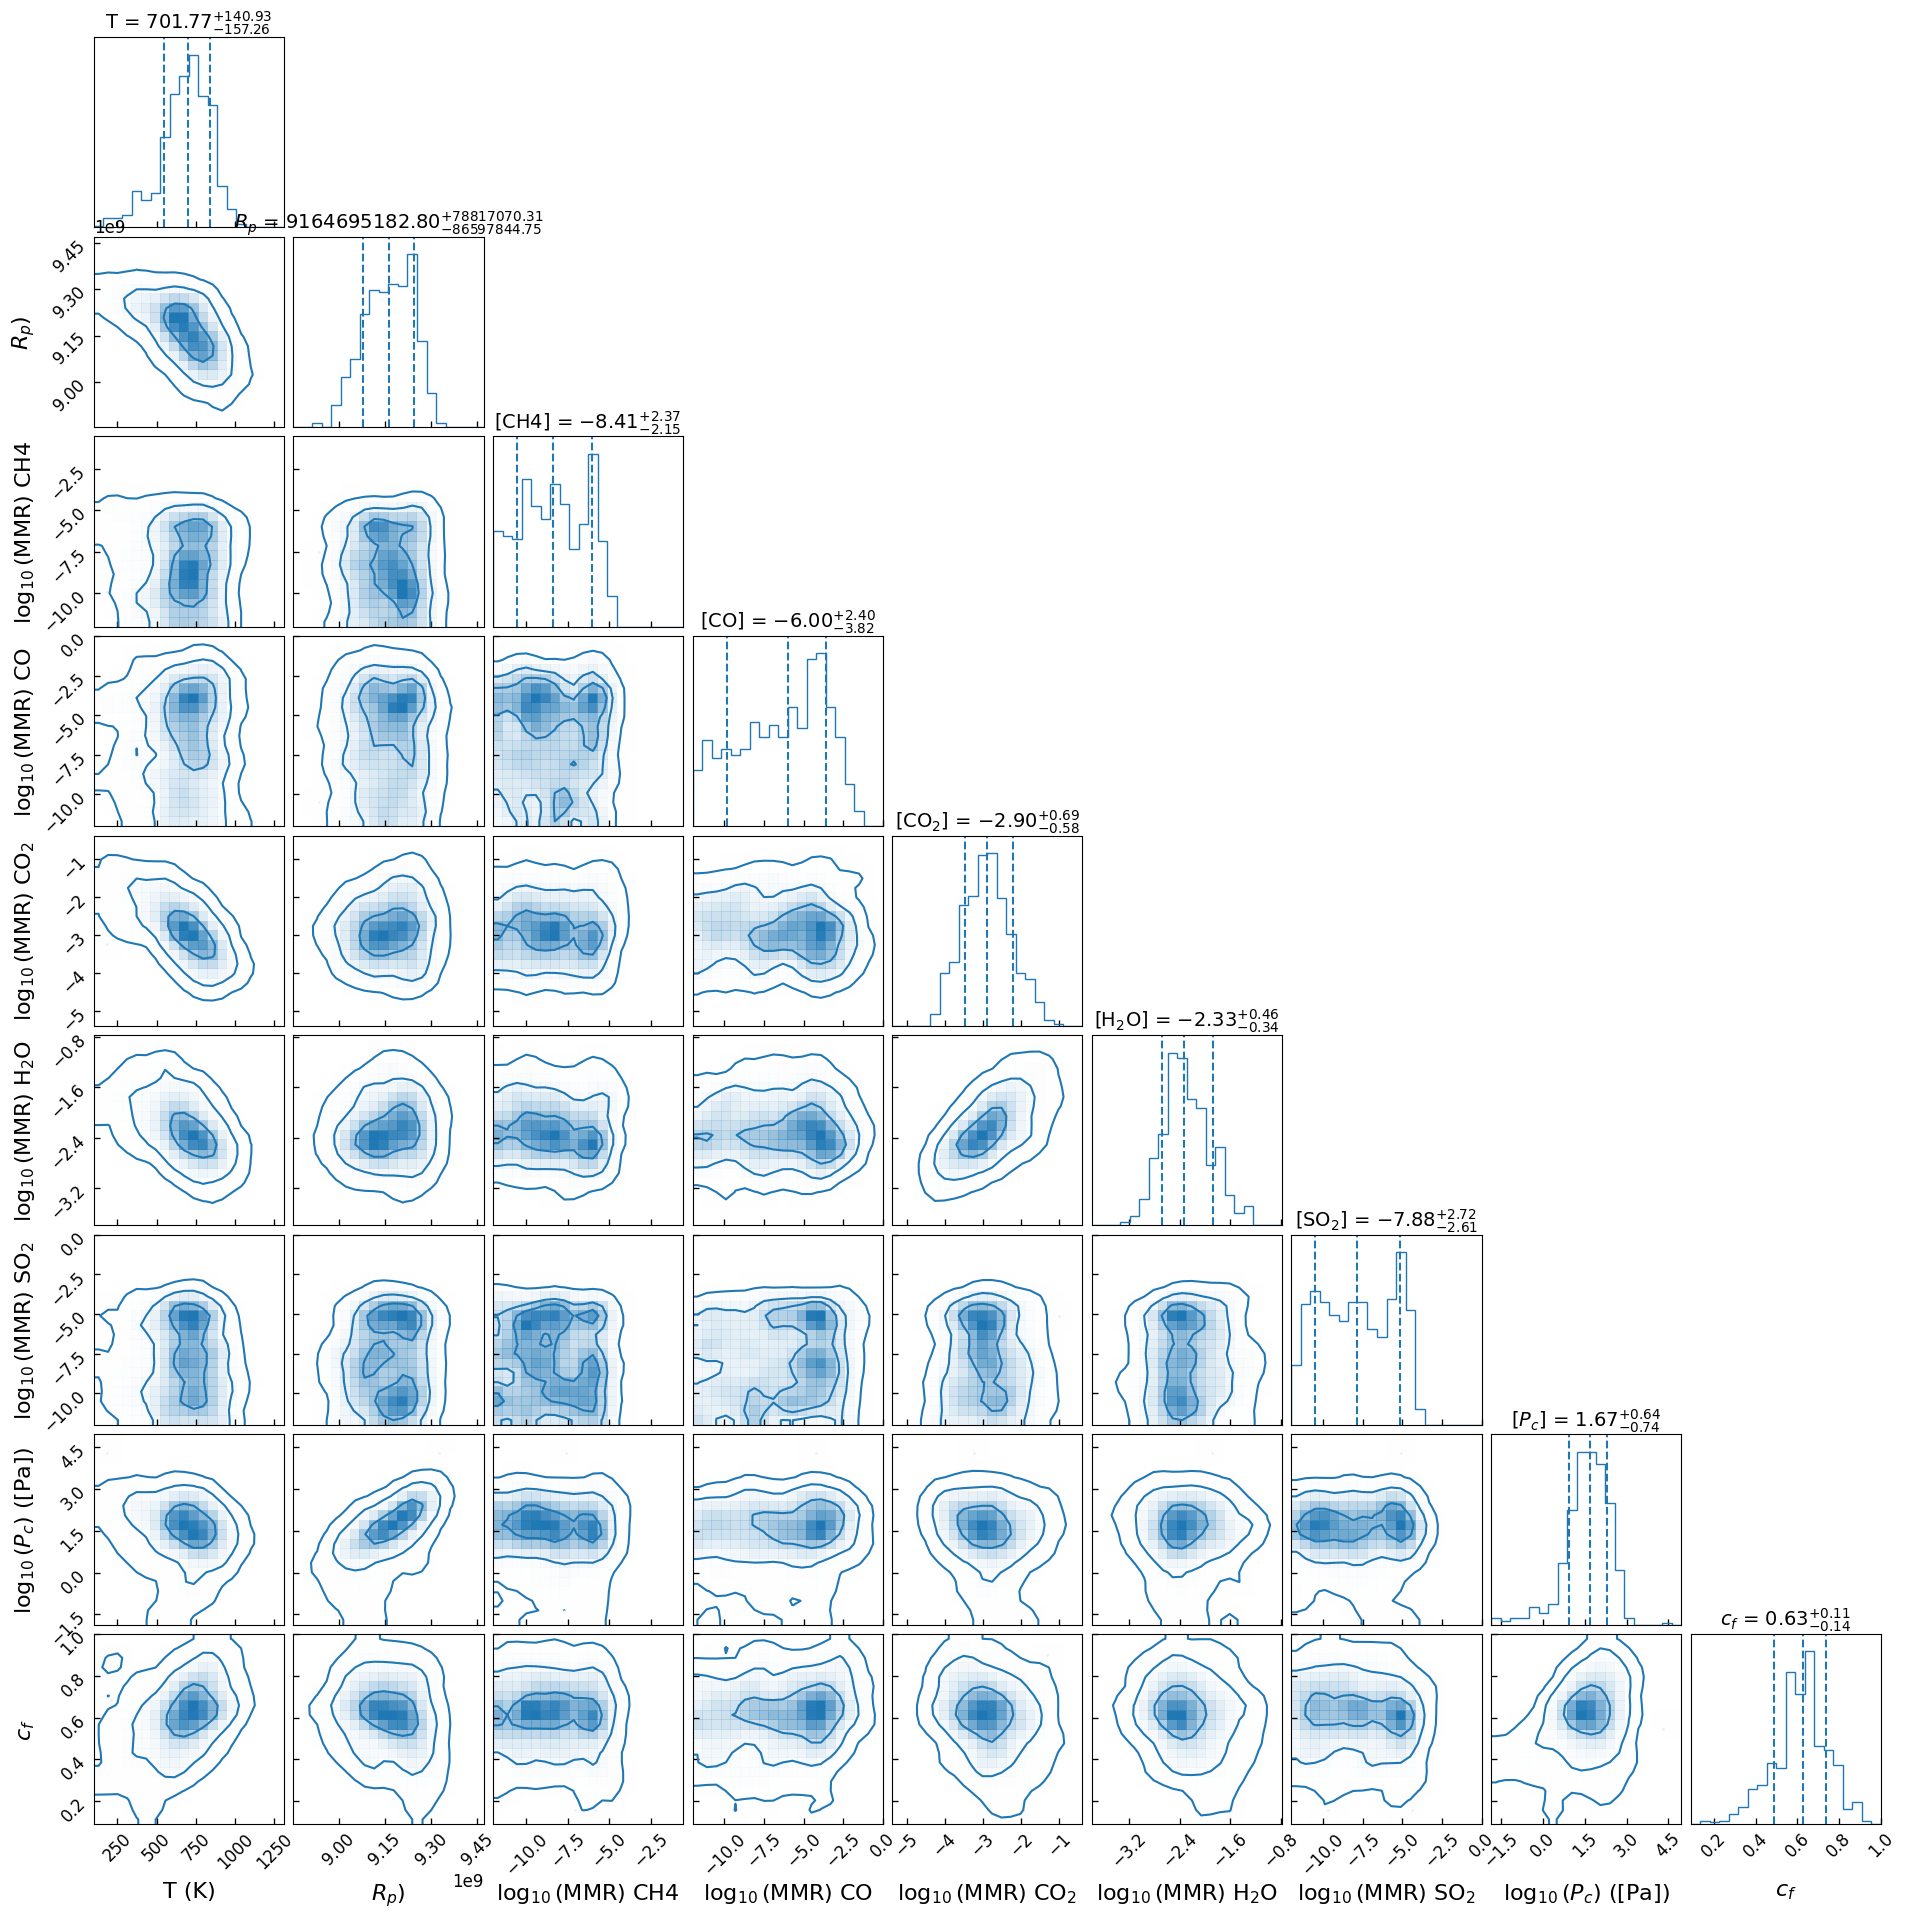

In [44]:
plot_result_corner(
    retrieval_directory=[
        retrieval_directory
    ],
    retrieved_parameters=retrieved_parameters,
    figure_name='corner_plot',
    label_kwargs={'fontsize': 16},
    title_kwargs={'fontsize': 14},
    figure_font_size=12,
    smooth=1,
    save=True,
    figure_directory=retrieval_directory,
    image_format='png'
)

Text(0, 0.5, 'Residuals ($\\sigma$)')

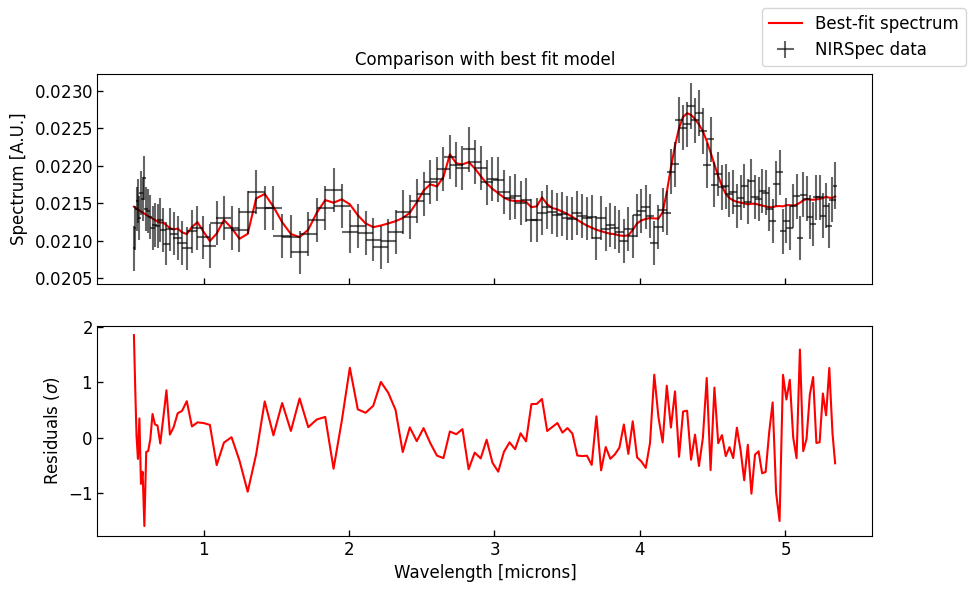

In [69]:
# Get the forward model with best-fit parameters
_, best_fit_spectra_nirspec, _ = retrieval.calculate_forward_model(
    parameters='best fit',
    data='NIRSpec'
)

fig, axes = plt.subplots(nrows=2, sharex='all', figsize = (10,6))

axes[0].plot(Wavelength, 1 - best_fit_spectra_nirspec[0, 0], ls='-', color='r', label='Best-fit spectrum')
axes[0].errorbar(Wavelength, Flux, xerr=bins, yerr=Flux_Error, ls='', label='NIRSpec data', color='k',alpha = 0.6)

fig.legend()

axes[1].plot(Wavelength, (1 - best_fit_spectra_nirspec[0, 0] - Flux) / Flux_Error, ls='-', color='r')

axes[0].set_title(rf'Comparison with best fit model')
axes[0].set_ylabel('Spectrum [A.U.]')
axes[1].set_xlabel('Wavelength [microns]')
axes[1].set_ylabel(r'Residuals ($\sigma$)')

Generating temporary Radtrans object with 'line_species': 'CH4.R300'
Loading Radtrans opacities...
 Loading line opacities of species 'CH4.R300' from file '/home/saurav/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__HITEMP.R300_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
Successfully loaded all opacities
Loading Radtrans opacities...
 Loading line opacities of species 'CH4.R300' from file '/home/saurav/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__HITEMP.R300_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
Successfully loaded all opacities
Generating temporary Radtrans object with 'line_species': 'CO-NatAbund.R300'
Loading Radtrans opacities...
 Loading line opacities of species 'CO-NatAbund.R300' from file '/home/saurav/petitRADTRANS/input_data/opacities/lines/correlated_k/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R300_0.1-250mu.ktable.petitRADTRANS.h5'... Do

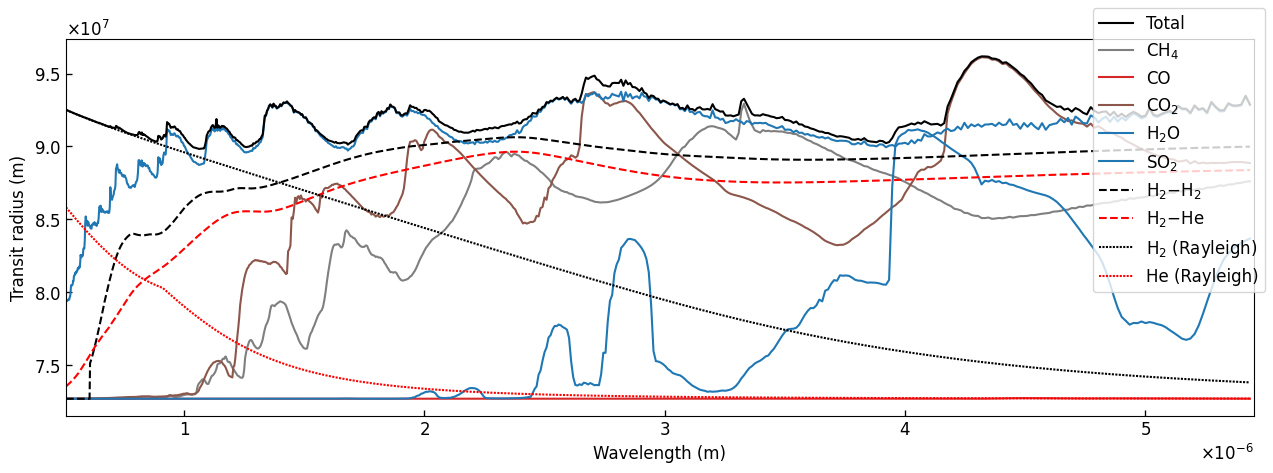

In [76]:
from petitRADTRANS.plotlib import plot_opacity_contributions
opacity_contributions = plot_opacity_contributions(
    forward_model_nirspec,
    mode='transmission',
    fill_below=False,
    x_axis_scale='linear'
)
plt.show()

Text(0, 0.5, 'P [bar]')

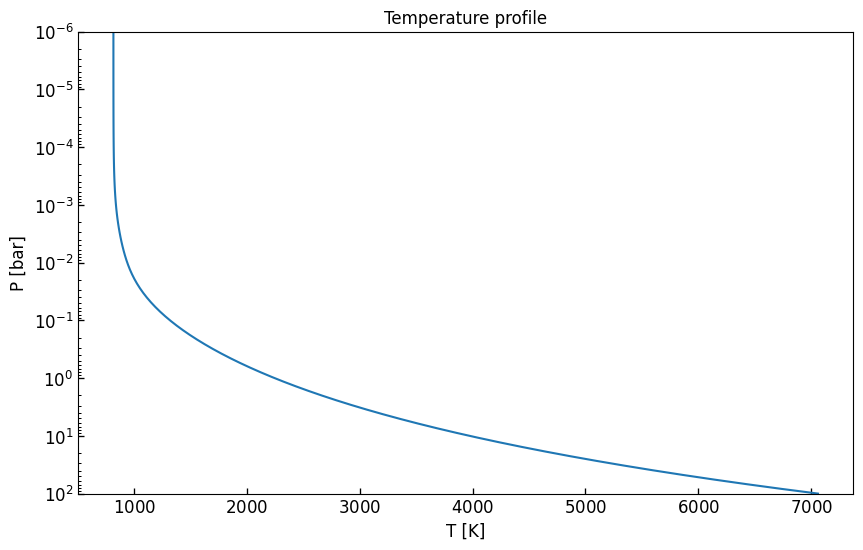

In [52]:
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(forward_model_nirspec.temperatures, forward_model_nirspec.pressures * 1e-6)
ax.set_yscale('log')
ax.set_ylim([1e2, 1e-6])
ax.set_title('Temperature profile')
ax.set_xlabel('T [K]')
ax.set_ylabel('P [bar]')

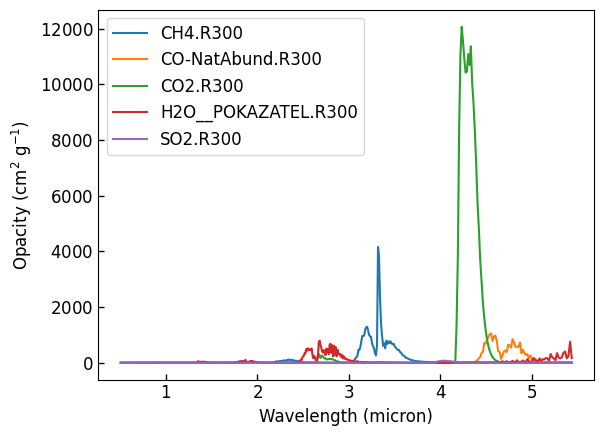

In [ ]:
from petitRADTRANS.plotlib import plot_radtrans_opacities

plot_radtrans_opacities(
    forward_model_nirspec,
    forward_model_nirspec.line_species,
    temperature=1100,
    pressure_bar=0.1
)
plt.ylabel('Opacity (cm$^2$ g$^{-1}$)')
plt.xlabel('Wavelength (micron)')
plt.legend()

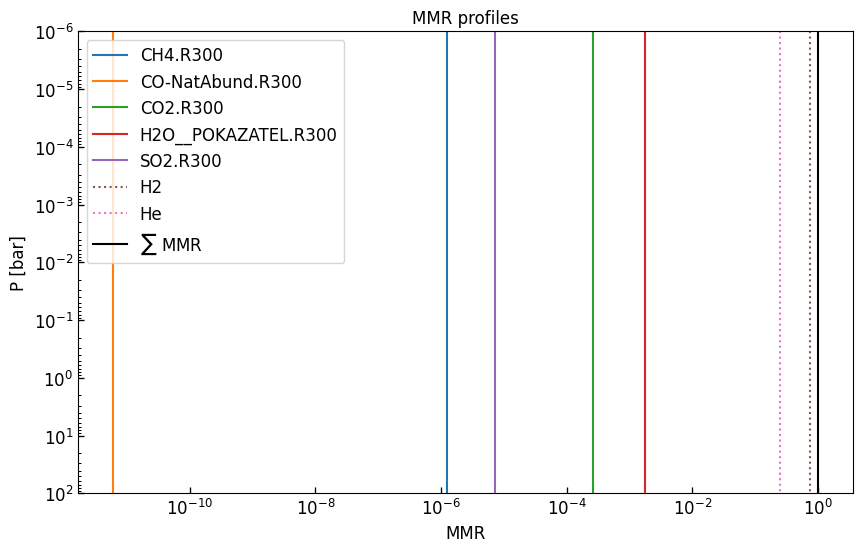

In [72]:
fig, ax = plt.subplots(figsize = (10,6))

for species, mass_fraction in forward_model_nirspec.mass_fractions.items():
    if species in forward_model_nirspec.line_species:
        ax.loglog(mass_fraction, forward_model_nirspec.pressures * 1e-6, label=species)

for species, mass_fraction in forward_model_nirspec.mass_fractions.items():
    if species in forward_model_nirspec.model_parameters['filling_species']:
        ax.loglog(mass_fraction, forward_model_nirspec.pressures * 1e-6, label=species, ls=':')

ax.loglog(np.sum(list(forward_model_nirspec.mass_fractions.values()), axis=0), forward_model_nirspec.pressures * 1e-6, label=r'$\sum$ MMR', color='k')

ax.set_ylim([1e2, 1e-6])
ax.set_title('MMR profiles')
ax.set_xlabel('MMR')
ax.set_ylabel('P [bar]')
ax.legend()